# Train model on MNIST Dataset

In [ ]:
import uuid
import shutil
import numpy as np
import cv2
import math
import pandas as pd
from PIL import Image
import torch
import time
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
from imutils.perspective import four_point_transform
import imutils
from google.colab.patches import cv2_imshow
from scipy.optimize import minimize_scalar
np.set_printoptions(threshold=np.inf)
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
!pip install np_utils
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
# Use the following line to install the torchvision library, if it is not already installed
# !conda install -y torchvision

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
from torch.utils.data import Dataset, DataLoader
from torch.distributions import normal
import time

import glob
from PIL import Image

In [ ]:
# Create and print the training dataset
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print("Print the training dataset:\n ", train_dataset)

# Create and print the validating dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print("Print the validating dataset:\n ", validation_dataset)

# Print the label
print("The label: ", train_dataset[3][1])

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Print the validating dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
The label:  1


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
IMAGE_SIZE = 28

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [ ]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [ ]:
# The label for the fourth data element
train_dataset[3][1]

1

torch.Size([1, 28, 28])


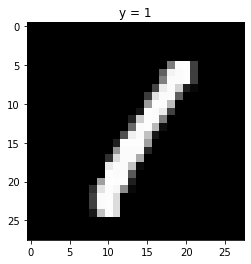

In [ ]:
show_data(train_dataset[3])
print(train_dataset[3][0].size())

In [ ]:

# the MNIST data is split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# Reshape to be samples*pixels*width*height
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# One hot Cpde
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

# convert from integers to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize to range [0, 1]
X_train = (X_train / 255.0)
X_test = (X_test / 255.0)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
______________________________________

In [ ]:
def evaluate_model(X_train, y_Train, n_folds=5):
    accuracy, data = list(), list()
    # prepare 5-cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)

    for x_train, x_test in kfold.split(X_train):
        # create model
        model = create_model()
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[x_train], y_Train[x_train], X_train[x_test], y_Train[x_test]
        # fit model
        data_fit = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=10, batch_size=32)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        # stores Accuracy 
        accuracy.append(acc)
        data.append(data_fit)
    return accuracy, data

In [ ]:
# summarize model performance
def summarize_performance(acc):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (numpy.mean(acc) * 100, numpy.std(acc) * 100, len(acc)))

    # box and whisker plots of results
    pyplot.boxplot(acc)
    pyplot.show()

In [ ]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 3000/60000 [>.............................] - ETA: 1:02 - loss: 1.2599 - accuracy: 0.6047

KeyboardInterrupt: ignored